# IS477 Project: Spotify Audio Feature Analysis

This notebook explores the evolution and characteristics of popular songs using two cleaned Spotify datasets. 

## 1. Setup and Data Loading

This section loads the two cleaned CSV files into pandas DataFrames and gives a quick overview of their size.

In [ ]:

import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

hp = pd.read_csv('data/High-Popularity-Spotify-Data-Cleaned.csv')
sp = pd.read_csv('data/Spotify-Tracks-Dataset-Cleaned.csv')

hp.shape, sp.shape


((1686, 28), (113999, 24))

## 2. Inspect Schema

Here we inspect the columns in each dataset to understand what information is available and how the two tables can be combined.

In [15]:

hp.columns.to_list()


['id',
 'track_id',
 'track_artist',
 'artist_clean',
 'track_name',
 'track_name_clean',
 'artist_track_key',
 'energy',
 'tempo',
 'danceability',
 'playlist_genre',
 'loudness',
 'liveness',
 'valence',
 'time_signature',
 'speechiness',
 'track_popularity',
 'track_href',
 'uri',
 'track_album_name',
 'track_album_release_date',
 'instrumentalness',
 'track_album_id',
 'mode',
 'key',
 'duration_ms',
 'acousticness',
 'type']

In [16]:
sp.columns.to_list()

['Archive',
 'Column',
 'track_id',
 'artists',
 'artists_clean',
 'album_name',
 'track_name',
 'track_clean',
 'popularity',
 'duration_ms',
 'explicit',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'track_genre']

## 3. Derive Year and Decade for High-Popularity Dataset

Only the high-popularity dataset includes explicit album release dates. We convert these to years and decades so we can study temporal trends in musical features.

In [17]:

hp['track_album_release_date'] = pd.to_datetime(hp['track_album_release_date'], errors='coerce')
hp['year'] = hp['track_album_release_date'].dt.year
hp[['track_album_release_date', 'year']].head()


,track_album_release_date,year
0,2024-08-16 00:00:00+00:00,2024
1,2024-05-17 00:00:00+00:00,2024
2,2024-10-18 00:00:00+00:00,2024
3,2024-08-23 00:00:00+00:00,2024
4,2024-10-18 00:00:00+00:00,2024


## 4. Create In-Memory SQL Database

We mirror both DataFrames into an in-memory SQLite database so that we can run SQL-style analysis alongside pandas operations.

In [18]:

conn = sqlite3.connect(':memory:')
hp.to_sql('spotify_popular', conn, index=False, if_exists='replace')
sp.to_sql('spotify_full', conn, index=False, if_exists='replace')
conn


## 5. SQL Helper: Correlation Function

SQLite does not provide a built-in correlation function, so we implement one using the standard covariance and variance formulas. This will let us calculate correlations using SQL queries when needed.

In [19]:

def corr_sql(table, x, y):
    query = f'''
    SELECT 
        (AVG({x} * {y}) - AVG({x}) * AVG({y})) /
        (sqrt(AVG({x} * {x}) - AVG({x}) * AVG({x})) *
         sqrt(AVG({y} * {y}) - AVG({y}) * AVG({y}))) AS correlation
    FROM {table};
    '''
    return pd.read_sql_query(query, conn)


## 6. Research Q1: Which Audio Attributes Correlate Most with Popularity?

We will utilize pandas to compute correlations between audio features and popularity in the high-popularity dataset. From this, we can identify which attributes are most strongly associated with popular songs through a visualization to find the top correlating features.

In [20]:

features = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']
hp_corr = hp[features + ['track_popularity']].corr()['track_popularity'].drop('track_popularity').sort_values(ascending=False)
hp_corr


loudness            0.083132
tempo               0.016659
liveness            0.004202
danceability       -0.002220
valence            -0.006478
energy             -0.007536
acousticness       -0.016960
instrumentalness   -0.063107
speechiness        -0.137957
Name: track_popularity, dtype: float64

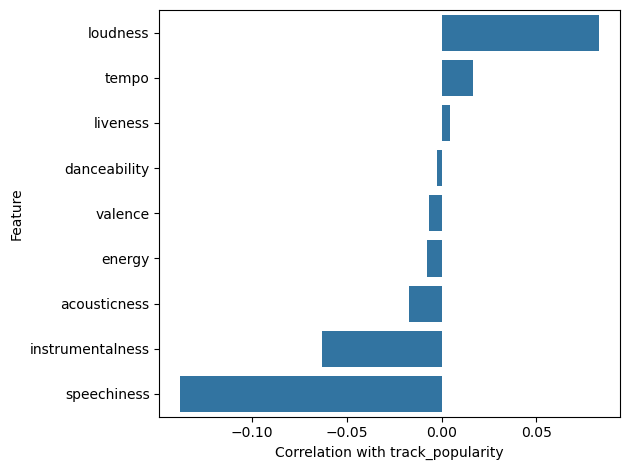

In [21]:

sns.barplot(x=hp_corr.values, y=hp_corr.index)
plt.xlabel('Correlation with track_popularity')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


From the graph, we can see that speechiness looks like the most strongly negatively correlated feature with popularity, while tempo and loudness appear to be the most positively correlated features.

In [48]:
print(corr_sql('spotify_popular', 'speechiness', 'track_popularity'))
print(corr_sql('spotify_popular', 'loudness', 'track_popularity'))
print(corr_sql('spotify_popular', 'tempo', 'track_popularity'))


   correlation
0    -0.137957
   correlation
0     0.083132
   correlation
0     0.016659


## 7. Research Q2: How Have Musical Features Evolved Across Time?

We can use the release year in the high-popularity dataset to construct decade-level trends for key audio features such as danceability, energy, valence, tempo, and loudness.

In [23]:

hp_decade = hp.dropna(subset=['year']).copy()
hp_decade['decade'] = (hp_decade['year'] // 10) * 10
agg_cols = ['danceability', 'energy', 'valence', 'tempo', 'loudness']
decade_trends = hp_decade.groupby('decade')[agg_cols].mean().reset_index()
decade_trends


,decade,danceability,energy,valence,tempo,loudness
0,1950,0.551500,0.303000,0.492000,127.899500,-10.985000
1,1960,0.543222,0.643000,0.645778,115.181889,-9.426889
2,1970,0.572893,0.633911,0.661179,122.385268,-9.955857
3,1980,0.576961,0.729786,0.631524,123.763049,-7.986087
4,1990,0.592022,0.726761,0.583746,115.829619,-7.174806
5,2000,0.599545,0.727681,0.548399,119.781322,-5.875881
6,2010,0.650304,0.638349,0.465477,120.715948,-6.606652
7,2020,0.691644,0.651908,0.517479,122.133407,-6.437191


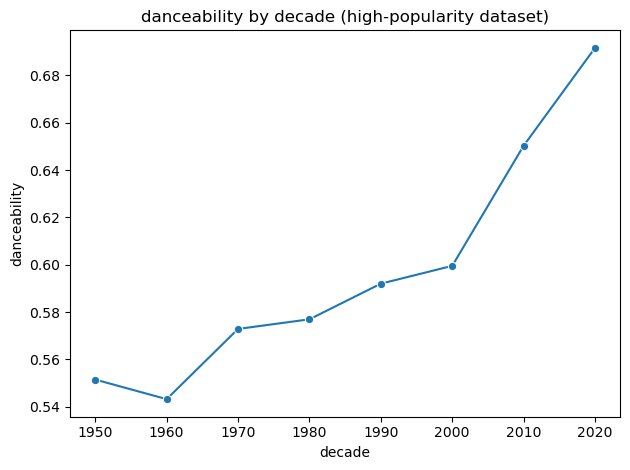

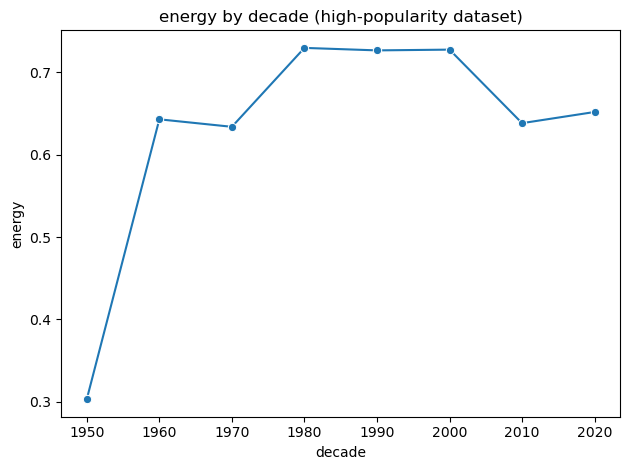

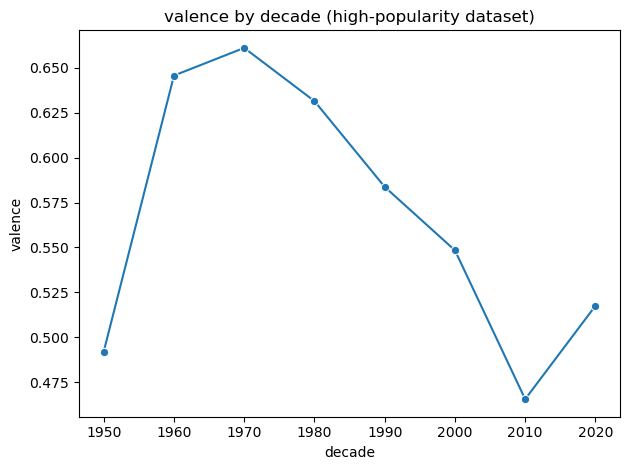

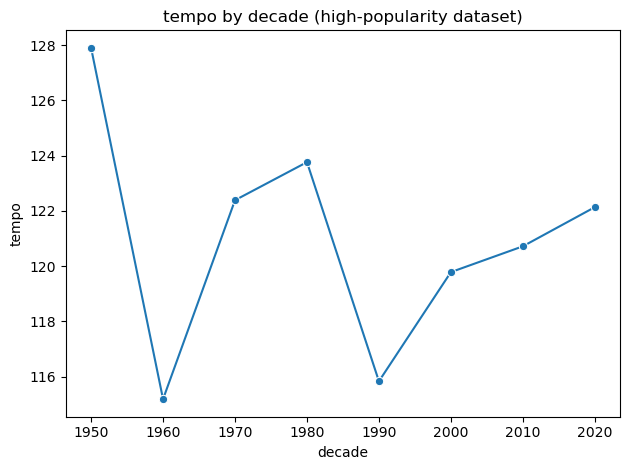

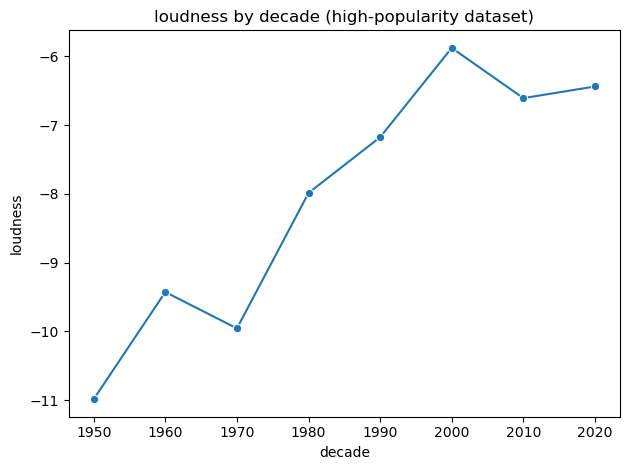

In [24]:

for col in agg_cols:
    sns.lineplot(data=decade_trends, x='decade', y=col, marker='o')
    plt.title(f'{col} by decade (high-popularity dataset)')
    plt.tight_layout()
    plt.show()


## 8. Research Q3: Can We Predict Popularity from Audio Features?

We label tracks in the full Spotify dataset as popular if their track IDs appear in the high-popularity dataset, then train a Random Forest classifier to distinguish popular from non-popular tracks based solely on audio features.

In [49]:

sp['is_popular'] = sp['track_id'].isin(hp['track_id']).astype(int)
sp['is_popular'].value_counts()


is_popular
0    113014
1       985
Name: count, dtype: int64

In [50]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

ml_features = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'acousticness']
ml_df = sp.dropna(subset=ml_features + ['is_popular'])
X = ml_df[ml_features]
y = ml_df['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)


(0.9953070175438596, 0.6687306501547987)

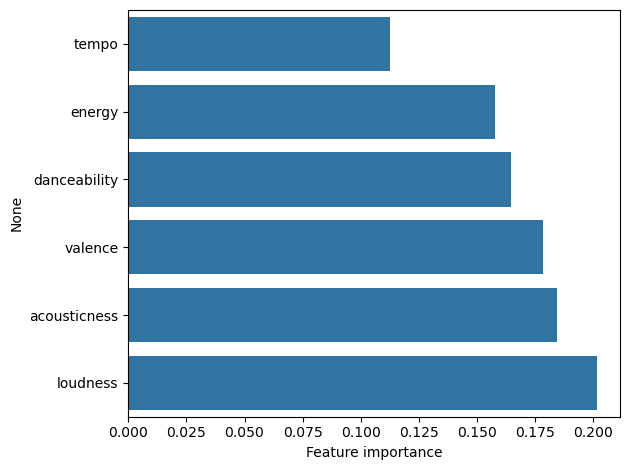

In [27]:

import numpy as np
importances = pd.Series(rf.feature_importances_, index=ml_features).sort_values(ascending=True)
sns.barplot(x=importances.values, y=importances.index)
plt.xlabel('Feature importance')
plt.tight_layout()
plt.show()


From the model that we generated, we can see that loudness and acousticness are the two most important features that our model used to predict popularity. This aligns with our earlier correlation analysis, where we found that loudness had a strong positive correlation with popularity. 

## 9. Research Q4: How Do Popularity Patterns Differ Across Genres and Clusters?

We compare feature distributions between popular and non-popular tracks, and we also examine genre-level differences in average popularity using SQL group-by queries.

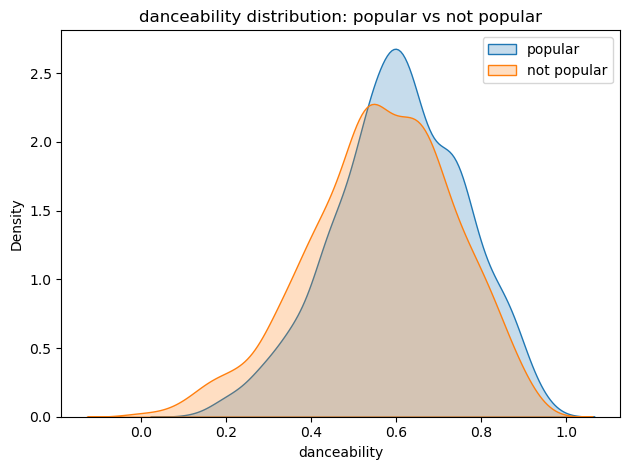

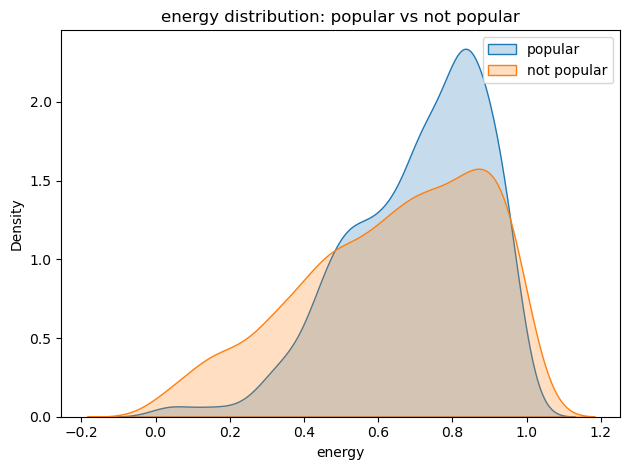

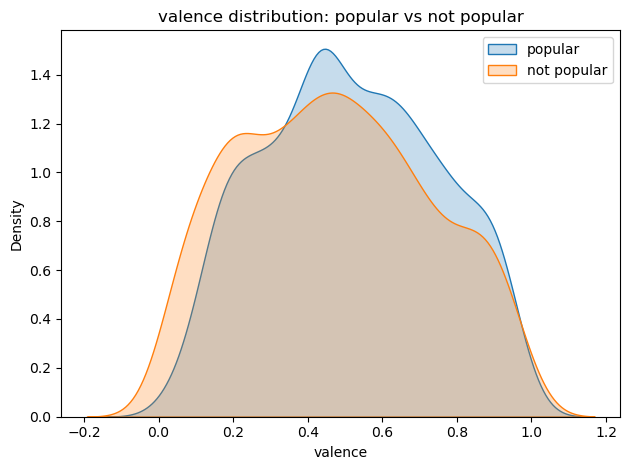

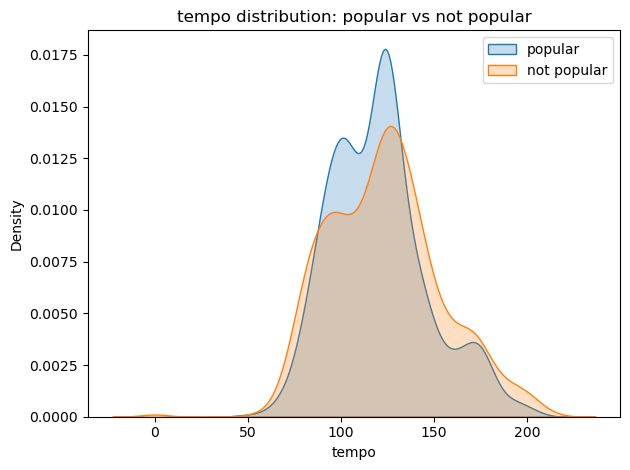

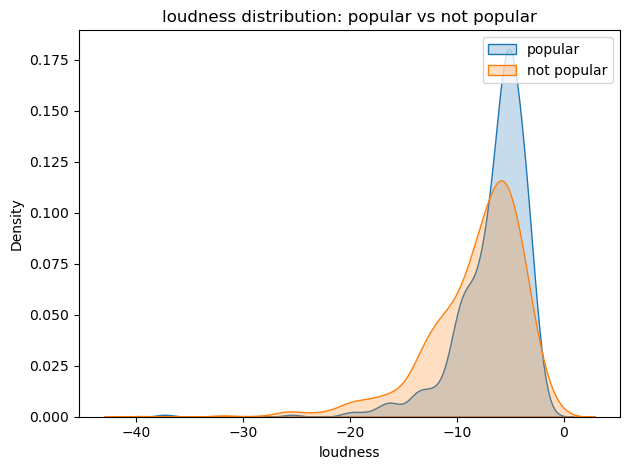

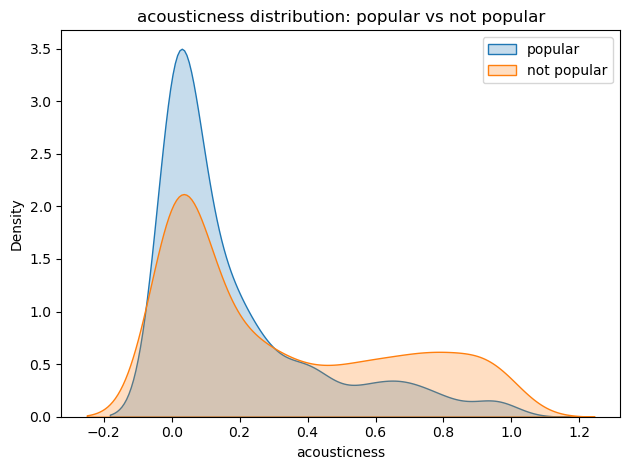

In [51]:

pop = ml_df[ml_df['is_popular'] == 1]
nonpop = ml_df[ml_df['is_popular'] == 0].sample(n=len(pop), random_state=42)
for col in ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'acousticness']:
    sns.kdeplot(pop[col], label='popular', fill=True)
    sns.kdeplot(nonpop[col], label='not popular', fill=True)
    plt.title(f'{col} distribution: popular vs not popular')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [29]:

query = '''
SELECT playlist_genre, AVG(track_popularity) AS avg_track_popularity, COUNT(*) AS n_tracks
FROM spotify_popular
GROUP BY playlist_genre
HAVING COUNT(*) >= 20
ORDER BY avg_track_popularity DESC
LIMIT 20;
'''
genre_pop_hp = pd.read_sql_query(query, conn)
genre_pop_hp


,playlist_genre,avg_track_popularity,n_tracks
0,gaming,80.430000,100
1,pop,80.042017,357
2,r&b,76.160000,50
3,latin,75.288043,184
4,folk,75.030303,33
5,rock,74.600000,235
6,ambient,74.278689,61
7,hip-hop,74.162996,227
8,arabic,73.980000,50
9,electronic,73.979730,148


In [30]:

query = '''
SELECT track_genre, AVG(popularity) AS avg_popularity, COUNT(*) AS n_tracks
FROM spotify_full
GROUP BY track_genre
HAVING COUNT(*) >= 100
ORDER BY avg_popularity DESC
LIMIT 20;
'''
genre_pop_sp = pd.read_sql_query(query, conn)
genre_pop_sp


,track_genre,avg_popularity,n_tracks
0,pop-film,59.283,1000
1,k-pop,56.896,1000
2,chill,53.651,1000
3,sad,52.379,1000
4,grunge,49.594,1000
5,indian,49.539,1000
6,anime,48.772,1000
7,emo,48.128,1000
8,sertanejo,47.866,1000
9,pop,47.576,1000


## 10. Combining Both Datasets Directly

Finally, we join the two datasets on `track_id` to see overlapping songs and compare their popularity scores and metadata side by side.

In [33]:

merged = hp.merge(sp, on='track_id', how='inner', suffixes=('_hp', '_sp'))
merged[['track_name_hp', 'artists', 'track_popularity', 'popularity']].drop_duplicates()


,track_name_hp,artists,track_popularity,popularity
0,hotel california - 2013 remaster,eagles,81,84
5,thunderstruck,ac/dc,83,84
7,seven nation army,the white stripes,82,84
11,creep,radiohead,86,85
15,californication,red hot chili peppers,81,82
...,...,...,...,...
1165,voyage voyage,desireless,70,70
1167,dernière danse,indila,77,76
1168,love story,indila,74,75
1169,tieduprightnow,parcels,71,70


From this, we can see that the two datasets merged well, allowing for richer analysis of popular music trends on Spotify. Now, we will modify this dataframe to see how the time between release date and 2023 affects popularity.

In [44]:
merged['release_date_parsed'] = pd.to_datetime(merged["track_album_release_date"], errors='coerce')
merged['release_year_hp'] = merged['release_date_parsed'].dt.year

merged = merged.rename(columns={
    "track_popularity": "popularity_hp",
    "popularity": "popularity_sp"
})

merged['years_since_release'] = 2023 - merged['release_year_hp']

merged['popularity_difference'] = merged['popularity_hp'] - merged['popularity_sp']

merged[['track_name_hp', 'artists', 'popularity_hp', 'popularity_sp', 
        'years_since_release', 'popularity_difference']].drop_duplicates()




,track_name_hp,artists,popularity_hp,popularity_sp,years_since_release,popularity_difference
0,hotel california - 2013 remaster,eagles,81,84,47,-3
5,thunderstruck,ac/dc,83,84,33,-1
7,seven nation army,the white stripes,82,84,20,-2
11,creep,radiohead,86,85,30,1
15,californication,red hot chili peppers,81,82,24,-1
...,...,...,...,...,...,...
1165,voyage voyage,desireless,70,70,22,0
1167,dernière danse,indila,77,76,9,1
1168,love story,indila,74,75,9,-1
1169,tieduprightnow,parcels,71,70,5,1


With this new, merged dataframe, we have the ability to analyze how the time since a track's release impacts its popularity in both datasets. The years_since_release column provides a way to quantify the difference in time from the song's release to the modern age of music. The popularity_difference column then allows us to use the popularity scores of the song in both datasets to see if there is a trend in how popularity changes over time. This, however, is some future work we can set up and will not be explored for the purpose of this project.